In [1]:
import numpy as np
from math import sin, cos, pi
from random import random, gauss
import matplotlib.pyplot as plt

In [2]:
def sigmoid(x: float) -> float:
    """
    ~Вычисляет значение сигмоидной функции активации для каждого элемента входного массива `x`
    и возвращает массив со значениями сигмоидной функции активации~

    :param x: @float@ входное значение
    :return: @float@ результат сигмоидной функии
    """
    return 1 / (1 + np.exp(-x))

In [3]:
def layer(npdata: np.ndarray, weight_arr: np.ndarray, bias_arr: np.ndarray, act_func) -> np.ndarray:
    """
    ~Вычисление выходных значений слоя нейронной сети при заданных входных значениях `npdata`,
    матрице весов `weight_list` и векторе смещений `bias_list` с использованием функции активации `act_func`~
    :param npdata: @np.ndarray@ массив данных (входной сигнал), размерность которого равна (n, m), где: n - количество признаков, m - количество примеров
    :param weight_arr: @np.ndarray@ массив весов, размерность которого равна (n, k), где k - количество нейронов в слое
    :param bias_arr: @np.ndarray@ массив смещений, размерность которого равна (1, k)
    :param act_func: @func@ функция активации, применяемая к выходу каждого нейрона
    :return: @np.ndarray@ массив, содержащий выходные значения нейронов в слое после применения функции активации к их суммарному входу. Размерность этого массива равна (m, k),
                          где m - количество примеров, k - количество нейронов в слое.
    """

    # Векторизованная версия функции активации act_f (функция будет применяться к каждому элементу numpy-массива,
    # в отличие от обычной функции, которая применяется только к одному значению)
    vf = np.vectorize(act_func)

    # Выполнение матричного умножения массива весов W на транспонированный массив данных npdata.T (транспонирование
    # результата матричного умножения для получения numpy-массива размерности (m, k)) и добавление массива смещений b
    # к каждой строке результата матричного умножения
    return vf(np.dot(weight_arr, npdata.T).T + bias_arr)

In [4]:
def layers(npdata: np.ndarray, weight_list: list, bias_list: list, act_func) -> list:
    """
    ~Функция вычисляет выходные значения для каждого слоя нейронной сети и возвращает список выходных
    значений для каждого слоя~

    :param npdata: @np.ndarray@ массив, который содержит входные данные для обработки
    :param weight_list: список @np.ndarray@ массивов, содержащих веса слоев нейронной сети
    :param bias_list: список @np.ndarray@ массивов, содержащих смещения слоев нейронной сети
    :param act_func: @func@ функция активации, которая будет применяться к выходу каждого слоя
    :return: список @np.ndarray@ выходных значений для каждого слоя

    [Функция принимает на вход матрицу входных данных npdata, список матриц весов `weight_list2`
    и список векторов смещений `bias_list` для каждого слоя нейронной сети, а также функцию активации `act_func`]
    """

    # примение функцию активации f к каждому элементу массива
    vf = np.vectorize(act_func)

    layers_data = [np.copy(npdata)]
    for weight_arr, bias_arr in zip(weight_list, bias_list):
        # К произведению матрицы весов weight_arr на входные данные layers_data[-1],
        # которые являются выходными данными предыдущего слоя добавляется смещение bias_arr и применяется
        # функция активации, в результате выходные данные слоя добавляются в список layers_data.
        layers_data.append(vf(np.dot(weight_arr, layers_data[-1].T).T + bias_arr))
    return layers_data

In [5]:
def layer_train(npdata: np.ndarray, nplabels: np.ndarray,
                init_weight_arr: np.ndarray, init_bias_arr: np.ndarray,
                act_func,
                mu: float, epoch: int = 100) -> (np.ndarray, np.ndarray):
    """
    ~Обучение одного слоя ИНС с использованием метода обратного распространения ошибки~

    :param npdata: @numpy.ndarray@ массив входных данных
    :param nplabels: @numpy.ndarray@ массив меток
    :param init_weight_arr: @numpy.ndarray@ массив инициализированных весовых коэффициентов
    :param init_bias_arr: @numpy.ndarray@ массив инициализированных коэффициентов смещения
    :param act_func: @func@ функция активации
    :param mu: @float@ коэффициент скорости обучения
    :param epoch: @int@ количество эпох обучения
    :return: (@np.ndarray@, @np.ndarray@) обученные значения начальных весов `init_weight_arr` и смещений `init_bias_arr`.

    [Функция принимает на вход матрицу входных данных `npdata`, матрицу ожидаемых выходных значений `nplabels`,
    начальные значения весов `init_weight_arr` и смещений `init_bias_arr`, функцию активации `act_func`,
    коэффициент обучения `mu` и количество эпох `epoch`]
    """

    # размерность массива меток nplabels
    nn = np.shape(nplabels)

    # Копии массивов init_weight_list и init_bias_list
    weight_list = np.copy(init_weight_arr)
    bias_list = np.copy(init_bias_arr)

    # Запуск цикла обучения на epoch эпох.
    for _ in range(epoch):
        # Результат прямого прохода через слой
        forwards = layer(npdata, weight_list, bias_list, act_func)

        # Ошибка на выходе слоя, используя формулу для метода обратного распространения ошибки
        delta = (forwards - nplabels) * forwards * (np.ones(nn) - forwards)

        # Обновление веса и смещения слоя с помощью градиентного спуска
        weight_list = weight_list - mu * np.dot(delta.T, npdata)
        bias_list = bias_list - mu * np.sum(delta)

    # Обновленные веса weight_list и смещения bias_list.
    return weight_list, bias_list

In [6]:
def generate_labels(source_layer_arr: np.ndarray, source_labels_arr: np.ndarray, weight_arr: np.ndarray) -> np.ndarray:
    """
    ~Генерирование метки для обучения следующего слоя нейронной сети~

    :param source_layer_arr: @np.ndarray@ вектор значений, полученный на выходе нейронной сети на определенном слое
    :param source_labels_arr: @np.ndarray@ вектор желаемых значений на данном слое
    :param weight_arr: @np.ndarray@ матрица весов, которая определяет связи между нейронами текущего слоя и предыдущего слоя
    :return: @np.ndarray@ метки для обучения следующего слоя
    """

    # source_layer - вектор, представляющий выходной слой нейронной сети
    # source_labels - вектор, представляющий истинные метки, которые мы хотим, чтобы ИНС предсказывала
    # Вычисление разницы между выходным слоем и истинными метками.
    # Затем применяется производная функция активации (в данном случае сигмоидальной функции) к выходному слою,
    # чтобы получить вектор delta.
    delta = (source_layer_arr - source_labels_arr) \
            * source_layer_arr \
            * (np.ones(np.shape(source_layer_arr)) - source_layer_arr)

    # Для улучшения точности предсказаний ИНС функция использует матрицу весов W для умножения вектора delta
    # и получения вектора ошибки на предыдущем слое. Затем этот вектор ошибки используется для обновления
    # весов на предыдущем слое.
    return np.dot(delta, weight_arr)

In [7]:
def ann_train(npdata, labels_dict: dict,
              init_weight_list: list, init_bias_list: list,
              act_func,
              mu: float = 0.05, epoch: int = 500) -> (list, list):
    """
    ~Реализация обучения нейронной сети методом обратного распространения ошибки с использованием градиентного спуска~

    :param npdata: массив данных для обучения ИНС
    :param labels_dict: @dict@ словарь меток для каждого слоя ИНС
    :param init_weight_list: список @np.ndarray@ массивов начальных весов ИНС
    :param init_bias_list: список @np.ndarray@ начальных смещений ИНС
    :param act_func: @func@ функция активации ИНС
    :param mu: @float@ скорость обучения ИНС
    :param epoch: @int@ количество эпох обучения ИНС (по умолчанию 500)
    :return: (@list@, @list@) обновленные веса начальных `init_weight_list` и смещения `init_bias_list` для ИНС
    """

    # Количество слоев в ИНС
    layers_number = len(init_bias_list)

    # список данных для каждого слоя
    layers_data = [np.copy(npdata)]

    # Список весовых матриц для каждого слоя ИНС
    weight_list = [np.copy(weight) for weight in init_weight_list]

    # Список векторов смещений для каждого слоя ИНС
    bias_list = [np.copy(bias) for bias in init_bias_list]

    # Основной цикл функции проходит по каждой эпохе обучения. Для каждой эпохи проходит цикл по каждому слою ИНС.
    for _ in range(epoch):
        # Для каждого слоя вычисляются выходные данные
        layers_data = layers(layers_data[0], weight_list, bias_list, act_func)

        # метки текущего слоя
        full_labels_dict = dict(labels_dict)

        for l in range(layers_number):
            sln = layers_number - l
            labels = labels_dict[sln - 1]

            if l:
                GL = generate_labels(layers_data[sln + 1], full_labels_dict[sln], weight_list[sln])

            for i, li in enumerate(labels):
                if float('inf') in li:
                    labels[i] = GL[i]

            full_labels_dict[sln - 1] = labels

            # Обучение каждого слоя методом обратного распространения ошибки с использованием градиентного спуска.
            # Обновленные весовые матрицы и векторы смещений сохраняются в WW и B.
            weight_list[sln - 1], bias_list[sln - 1] = layer_train(
                layers_data[sln - 1],
                full_labels_dict[sln - 1],
                weight_list[sln - 1],
                bias_list[sln - 1],
                act_func,
                mu,
                1)
    return weight_list, bias_list

In [8]:
def get_n(phi: int, psi: int) -> np.ndarray:
    """
    ~Генерируют входные данные для нейронной сети на основе косинуса и синуса углов `phi` и `psi`
    для вычисления компонент вектора `n` в трехмерном пространстве~

    :param phi: @int@ угол `phi`
    :param psi: @int@ угол `psi`
    :return: @np.ndarray@ массив компонент вектора `n` в трехмерном пространстве

    [Вектор `n` представляет собой единичный вектор, направление которого определяется углами `phi` и `psi`.
    Он может использоваться для различных целей, таких как определение направления движения объекта в пространстве
    или ориентации объекта относительно других объектов]
    """

    return np.array([cos(phi) * cos(psi), sin(phi) * cos(psi), sin(psi)])

In [9]:
def get_x(T: int) -> np.ndarray:
    """
    ~Функция генерации входных данных для нейронной сети~

    :param T: @int@ входное число
    :return:  массив @np.ndarray@ размера `Tx3` элементов целочисленного значения от `0` до `T-1`

    [Функция принимает на вход число `T` и возвращает numpy массив размера `Tx3` элементов
    целочисленного значения от `0` до `T-1`]
    """

    return np.array([[t / T, (t / T) ** 2, (t / T) ** (1 / 2)] for t in range(T)])

In [10]:
def start(i: int) -> float:
    """
    ~Генерирует начальные значения для входных данных~

    :param i: @int@ входящее число
    :return:  @float@ `0` | `1` | `random{-1, 1}`

    [Возвращает 0, 1 или случайное число (в интервале от -1 до 1) в зависимости от значения аргумента `i`:
    {-inf, 3}: 0
    {3, 6}: 1
    {6, 9}: 0
    {9, inf}: random{-1, 1}]
    """

    if i < 3 or 5 < i < 9:
        return 0
    elif i < 6:
        return 1
    else:
        return 2 * random() - 1

In [11]:
def generate_f(T: int, A: int, mexp: float = 0.5, stdiv: float = 0.2) -> list:
    """
    ~Генерация случайных значений из нормального распределения с математическим ожиданием `mexp`
    и стандартным отклонением `stdiv` для входных данных~

    :param T: @int@ длина данных
    :param A: @int@ ширина данных
    :param max_exp: @float@ математическое ожидание (по умолчанию, 0.5)
    :param stdiv: @float@ величина стандартного отклонения (по умолчанию, 0.2)
    :return: список @np.array@ массивов случайных значений
    """

    phi, psi = random() * 2 * pi, random() * pi - pi / 2
    direction = [get_n(phi, psi) for _ in range(A)]
    return [np.array([gauss(mexp, stdiv) * direction[a] for a in range(A)]) for _ in range(T)]

In [12]:
def umpf(step_num: int, expected_values_list: list, current_values_arr: np.ndarray, gamma: int) -> np.ndarray:
    """
    ~Вычисляет матрицу входных данных для каждого слоя нейронной сети~

    :param step_num: @int@ номер текущего шага
    :param expected_values_list: список @np.ndarray@ массивов значений, представляющих собой целевые значения, которые должна достичь система
    :param current_values_arr: массив @np.ndarray@ значений, представляющих собой текущее состояние системы
    :param gamma: @int@ пороговое значение для функции управления при обучении ИНС
    :return: массив @np.ndarray@ матрицы входных данных для каждого слоя нейронной сети

    [В алгоритме происходит вычисление управляющего воздействия `vul` на текущем шаге времени,
    используя значения управляющего воздействия с предыдущего шага времени и состояния системы на текущем
    и предыдущем шагах времени. Если текущий шаг времени кратен `Tp`, то функция также вычисляет
    состояние системы на следующем шаге времени `vpl1`.
    Если текущий шаг времени кратен `Tu`, то функция вычисляет управляющее воздействие на следующем шаге времени `vml`]
    """

    arr_zero = np.array([[0] * 3] * A)
    arr_inf = np.array([[float('inf')] * 3] * A)

    # состояние системы на текущем шаге времени
    vpl = arr_inf
    # состояние системы на следующем шаге времени
    vpl1 = arr_inf

    # vul - управляющее воздействие на текущем шаге времени
    vul = arr_inf

    # vml - ?
    vml = arr_inf

    # если текущий шаг времени кратен Tp
    if not step_num % Tp:
        # состояние системы на текущем шаге времени
        vpl = np.array([list(current_values_arr[step_num])] * A)

        # состояние системы на следующем шаге времени
        vpl1 = np.array([list(current_values_arr[step_num + 1])] * A)

    # если текущий шаг времени кратен Tu
    if not step_num % Tu:
        # vul - управляющее воздействие на текущем шаге времени
        vul = expected_values_list[step_num - 1] - 1 / gamma * (vpl1 - vpl)

    if step_num == len(expected_values_list):
        vml = arr_zero

    return np.hstack((vul, vml, vpl, expected_values_list[step_num - 1]))

In [13]:
def abs_value(x) -> float: 
    """
    Вычисляет абсолютную величину вектора x
    """
    return (sum([xi**2 for xi in x]))**(1/2)

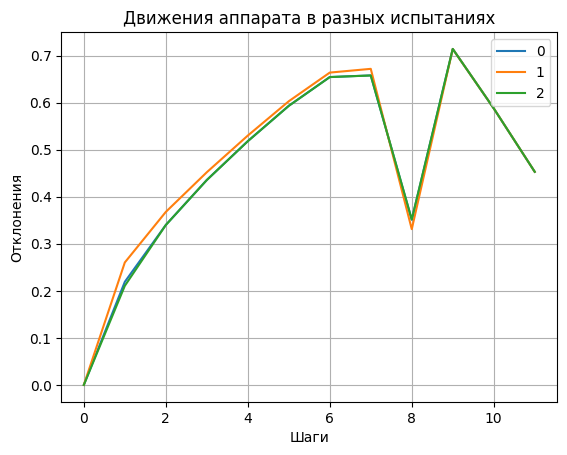

[0.07692152 0.07420447 0.07739557] [0.0702296  0.06804906 0.07060853]


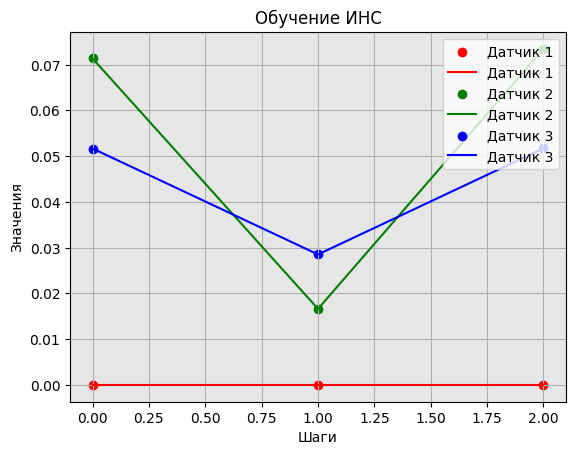

In [14]:
if __name__ == "__main__":

    # Количество образцов данных при обучении ИНС
    A = 3

    # количество временных отсчетов при обучении ИНС
    T = 12

    # Количество нейронов сети
    N = 12

    # период обновления входных данных
    Tu = 4

    # период обновления выходных данных
    Tp = 2

    # гамма, пороговое значение для функции управления при обучении ИНС.
    gm = 20

    # В основной части кода задаются параметры нейронной сети и вызывается функция `ann_train`
    # для обучения нейронной сети. Выводятся результаты работы нейронной сети.
    npdata = np.array([[start(i) for i in range(T)] for _ in range(A)])
    X = get_x(T + 2)
    F = generate_f(T, A)
    labels_dict = {}
    for l in range(1, T + 1):
        labels_dict[l - 1] = umpf(l, F, X, gm)

    init_weight_list2 = [np.array([[0.2 * random() + 0.9 for _ in range(N)] for _ in range(N)]) for _ in range(T)]
    init_bias_list = [np.array([0 for _ in range(N)]) for _ in range(T)]

    weight_list2, bias_list = ann_train(npdata, labels_dict, init_weight_list2, init_bias_list, sigmoid, 0.05, 100)
    Ld = layers(npdata, weight_list2, bias_list, sigmoid)
    """ 
    Ld содержит информацию о T шагах движения аппарата. 
    Для каждого шага имеется матрица: ее строки соответствуют 
    экземплярам данных (то есть разным местам или временам испытаний),
    а столбцы - показаниям датчиков в этом испытании.
    Визуализируем абсолютную величину отклонения аппарата от 
    желаемой траектории в каждый момент времени в каждом испытании.
    """
    _data = []
    for a in range(A):
        dx = [np.array(Ld[t][a][6:9]) - X[t] for t in range(T)]
        abs_dx = list(map(abs_value,dx))
        _data.append(abs_dx) 
    #colors = ("red", "green", "blue")
    for a in range(A):
        plt.plot(range(T),_data[a],label = str(a))
    plt.xlabel("Шаги")
    plt.ylabel("Отклонения")
    plt.title("Движения аппарата в разных испытаниях")
    plt.legend(loc=1)
    plt.grid()
    plt.show()
    
    print(Ld[5][0][6:9], Ld[5][1][6:9])
    #
    _data = list()
    for step in range(T):
       steps = [_a for _a in range(A)]
       d = (steps, [Ld[step][a][0] for a in range(A)])
       _data.append(d)
    data = tuple(_data)
    #
    colors = ("red", "green", "blue")
    groups = ("Датчик 1", "Датчик 2", "Датчик 3")
    fig = plt.figure()
    Z = fig.add_subplot(1, 1, 1, facecolor='#E6E6E6')
    for data, color, group in zip(data, colors, groups):
       x, y = data
       Z.scatter(x, y, c=color, label=group)
       Z.plot(x, y, c=color, label=group)
    plt.xlabel("Шаги")
    plt.ylabel("Значения")
    plt.title("Обучение ИНС")
    plt.legend(loc=1)
    plt.grid()
    plt.show()